# Experimento 2 - Variação entre Perfis

**Objetivo**: Verificar se a mesma pergunta gera respostas significativamente diferentes quando o perfil do usuário varia.

**Metodologia**:
* Escolher 3 perfis de usuário,
* Escolher 10 perguntas,
* Para cada pergunda, gerar uma resposta para cada perfil.
* Aplicar métricas de similaridade semântica (BERTScore, Similaridade Cosseno, etc) entre as respostas para uma mesma pergunta.

In [3]:
import json
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.metrics.distance import edit_distance
from bert_score import score as bert_score
import numpy as np

In [2]:
# Carregar arquivo JSON com respostas dos três perfis
with open("/Users/gustavolgcr/doutorado/implementacoes/experiments/src/data/questions_and_answers_experiment_2.json", "r", encoding="utf-8") as f:
    dados = json.load(f)

df = pd.DataFrame(dados)
df.head()

,pergunta,resposta_torcedor,resposta_tecnico,resposta_narrador
0,Quais jogadores mais se destacaram no jogo con...,No jogo contra o Ceará no dia 1º de abril de 2...,"No jogo contra o Ceará, realizado em 1º de abr...","No jogo contra o Ceará, realizado em 1º de abr..."
1,O que os dados mostram sobre o desempenho do t...,"No segundo tempo do jogo contra o Ceará, reali...","No segundo tempo do jogo contra o Ceará, reali...","No segundo tempo do jogo contra o Ceará, reali..."
2,Qual jogador teve o maior impacto físico duran...,O jogador que se destacou com o maior impacto ...,O jogador que teve o maior impacto físico dura...,Durante o jogo contra o Ceará no dia 1º de abr...
3,Como foi o desempenho geral da equipe na parti...,Na emocionante partida contra o Ceará no dia 1...,Na partida contra o Ceará no dia 1º de abril d...,Na partida contra o Ceará no dia 1º de abril d...
4,Quem foram os jogadores mais decisivos durante...,"Na emocionante partida contra o Ceará, os joga...","Na partida contra o Ceará, os jogadores que se...","Durante a partida contra o Ceará, os jogadores..."


In [39]:
def cosine_sim(text1, text2):
    vect = TfidfVectorizer().fit([text1, text2])
    tfidf = vect.transform([text1, text2])
    sim = cosine_similarity(tfidf[0], tfidf[1])[0][0]
    return round(sim, 4)

def normalized_edit_distance(t1, t2):
    dist = edit_distance(t1, t2)
    return round(dist / max(len(t1), len(t2)), 4)

def get_all_metrics(t1, t2):
    P, R, F1 = bert_score([t1], [t2], lang="pt", verbose=False)
    return {
        "BERTScore": round(F1[0].item(), 4),
        "CosineSim": cosine_sim(t1, t2),
        "EditDist": normalized_edit_distance(t1, t2),
    }

**Similaridade Cosseno**: mede a similaridade semântica entre os dois textos com base no conteúdo de palavras.
* Varia de 0 (totalmente diferentes) a 1 (idênticos em termos de conteúdo de palavras).
* Exemplo: "o jogador foi bem" vs "o atleta se destacou" pode dar algo como 0.6.

**Edit Distance**: mede o número de operações (inserção, deleção, substituição) necessárias para transformar um texto no outro.
* Valor baixo → textos semelhantes; Valor alto → textos muito diferentes.
* Gira em torno de 0 a 1, com 0 indicando textos idênticos.

**BERTScore**: usa embeddings de um modelo de linguagem (como BERT ou RoBERTa) para medir similaridade semântica profunda entre os textos.
* Escala de 0 a 1, sendo 1 perfeitamente equivalente.

In [40]:
resultados = []

for item in dados:
    pergunta = item["pergunta"]
    pares = [
        ("Torcedor vs Técnico", item["resposta_torcedor"], item["resposta_tecnico"]),
        ("Torcedor vs Narrador", item["resposta_torcedor"], item["resposta_narrador"]),
        ("Técnico vs Narrador", item["resposta_tecnico"], item["resposta_narrador"]),
    ]
    
    for par_nome, t1, t2 in pares:
        metrics = get_all_metrics(t1, t2)
        metrics["pergunta"] = pergunta
        metrics["comparacao"] = par_nome
        resultados.append(metrics)

df_resultados = pd.DataFrame(resultados)
df_resultados.head()

,BERTScore,CosineSim,EditDist,pergunta,comparacao
0,0.9563,0.9795,0.1510,Quais jogadores mais se destacaram no jogo con...,Torcedor vs Técnico
1,0.6491,0.2698,0.7454,Quais jogadores mais se destacaram no jogo con...,Torcedor vs Narrador
2,0.6773,0.2764,0.7401,Quais jogadores mais se destacaram no jogo con...,Técnico vs Narrador
3,0.8107,0.6745,0.6418,O que os dados mostram sobre o desempenho do t...,Torcedor vs Técnico
4,0.8129,0.6232,0.6135,O que os dados mostram sobre o desempenho do t...,Torcedor vs Narrador


In [7]:
df_resultados.groupby("comparacao")[["BERTScore", "CosineSim", "EditDist"]].agg(["mean", "std"]).round(4)

BERTScore         CosineSim         EditDist        
                          mean     std      mean     std     mean     std
comparacao                                                               
Torcedor vs Narrador    0.8816  0.0304    0.5596  0.1516   0.6221  0.0866
Torcedor vs Técnico     0.8878  0.0305    0.5887  0.1859   0.6037  0.1752
Técnico vs Narrador     0.8914  0.0372    0.6098  0.1558   0.5750  0.1330

Embora as análises quantitativas (BERTScore, Cosine Similarity, Edit Distance) apontem para variações entre as respostas dos diferentes perfis, os valores médios das métricas indicam que tais variações são modestas. Isso sugere que o modelo gera uma estrutura de resposta relativamente comum, ajustando elementos como vocabulário, tom ou ênfase, mas sem grandes modificações semânticas ou estruturais. Esse resultado levanta a hipótese de que, em domínios com dados factuais consistentes entre perfis, a personalização pode ocorrer mais em aspectos superficiais (estilo, apresentação) do que no conteúdo central. Tal observação reforça a necessidade de mecanismos mais robustos para controle de estilo e foco no módulo de personalização.

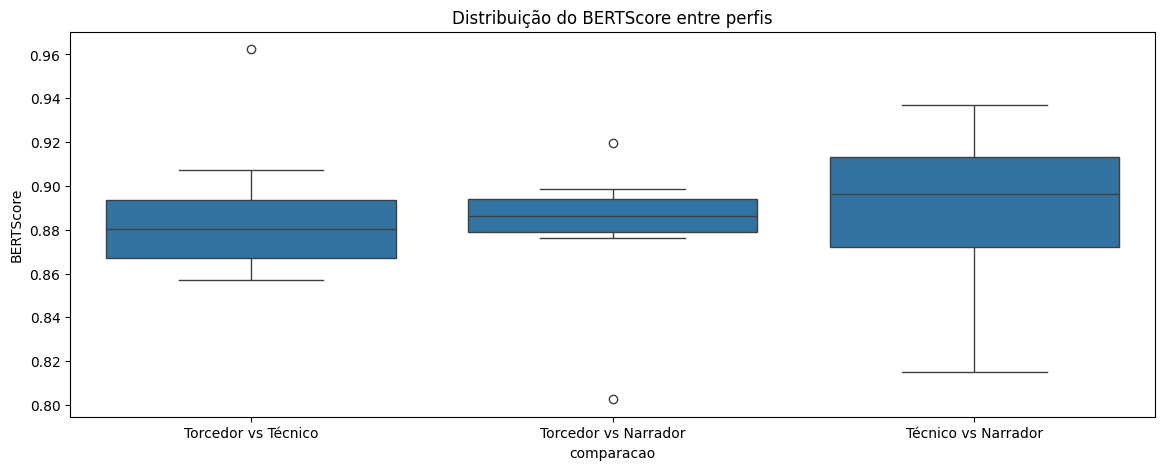

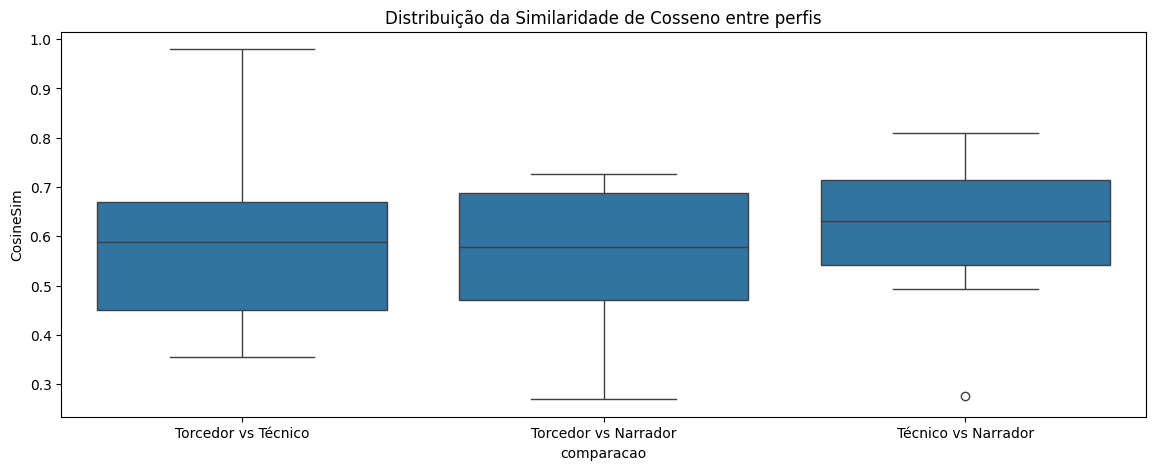

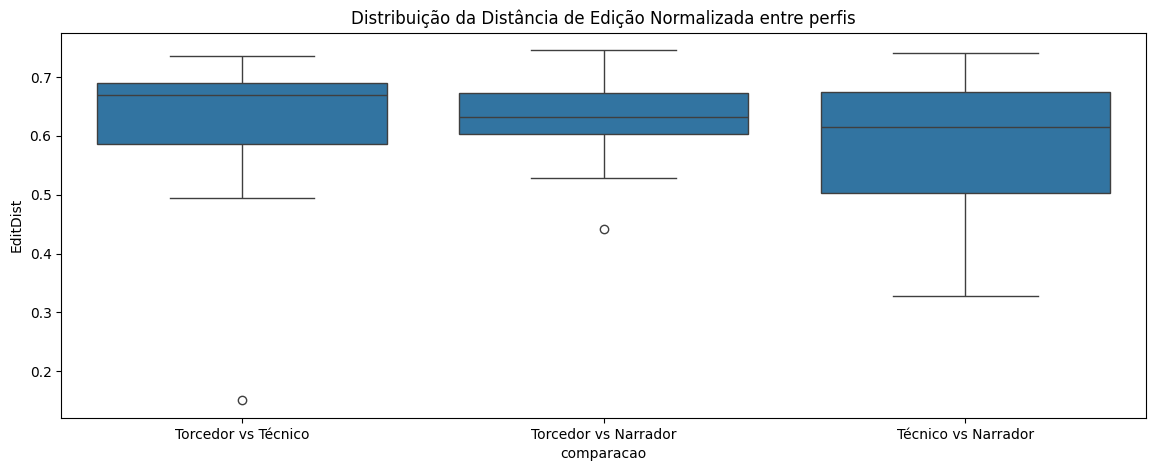

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
sns.boxplot(data=df_resultados, x="comparacao", y="BERTScore")
plt.title("Distribuição do BERTScore entre perfis")
plt.show()

plt.figure(figsize=(14, 5))
sns.boxplot(data=df_resultados, x="comparacao", y="CosineSim")
plt.title("Distribuição da Similaridade de Cosseno entre perfis")
plt.show()

plt.figure(figsize=(14, 5))
sns.boxplot(data=df_resultados, x="comparacao", y="EditDist")
plt.title("Distribuição da Distância de Edição Normalizada entre perfis")
plt.show()

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import pi

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import jaccard_score
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
from difflib import SequenceMatcher
from bert_score import score as bert_score

import pandas as pd
import numpy as np
import torch

# Lista de pares de perfis
pares = [
    ("torcedor", "tecnico"),
    ("torcedor", "narrador"),
    ("tecnico", "narrador")
]

# Funções de distância
def jaccard_similarity(text1, text2):
    vect = CountVectorizer(binary=True)
    X = vect.fit_transform([text1, text2]).toarray()
    
    if X.shape[1] < 2:
        # Vetor com apenas uma dimensão — Jaccard não aplicável
        return 0.0
    
    return jaccard_score(X[0], X[1], average='binary')

def bleu(a, b):
    return sentence_bleu([b.split()], a.split())

def rouge_l(a, b):
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    return scorer.score(a, b)['rougeL'].fmeasure

def edit_distance_ratio(a, b):
    return SequenceMatcher(None, a, b).ratio()

# Construir DataFrame
linhas = []
for exemplo in dados:
    pergunta = exemplo["pergunta"]
    
    respostas = {
        "torcedor": exemplo["resposta_torcedor"],
        "tecnico": exemplo["resposta_tecnico"],
        "narrador": exemplo["resposta_narrador"]
    }

    for a, b in pares:
        res_a = respostas[a]
        res_b = respostas[b]

        # Calcular BERTScore
        P, R, F1 = bert_score([res_a], [res_b], lang="pt", rescale_with_baseline=True)
        bert = F1[0].item()

        linhas.append({
            "pergunta": pergunta,
            "par": f"{a}-{b}",
            "perfil_a": a,
            "perfil_b": b,
            "BERTScore": round(bert, 4),
            "BLEU": round(bleu(res_a, res_b), 4),
            "ROUGE_L": round(rouge_l(res_a, res_b), 4),
            "Jaccard": round(jaccard_similarity(res_a, res_b), 4),
            "Edit_Dist": round(edit_distance_ratio(res_a, res_b), 4)
        })

df_variacao = pd.DataFrame(linhas)
df_variacao.head()

,pergunta,par,perfil_a,perfil_b,BERTScore,BLEU,ROUGE_L,Jaccard,Edit_Dist
0,Quais jogadores mais se destacaram no jogo con...,torcedor-tecnico,torcedor,tecnico,0.8816,0.6688,0.8668,0.5463,0.8466
1,Quais jogadores mais se destacaram no jogo con...,torcedor-narrador,torcedor,narrador,0.0489,0.0836,0.1951,0.5100,0.1045
2,Quais jogadores mais se destacaram no jogo con...,tecnico-narrador,tecnico,narrador,0.1254,0.1049,0.2201,0.4906,0.1032
3,O que os dados mostram sobre o desempenho do t...,torcedor-tecnico,torcedor,tecnico,0.4869,0.2644,0.4333,0.3116,0.2154
4,O que os dados mostram sobre o desempenho do t...,torcedor-narrador,torcedor,narrador,0.4929,0.2471,0.4320,0.3185,0.2655


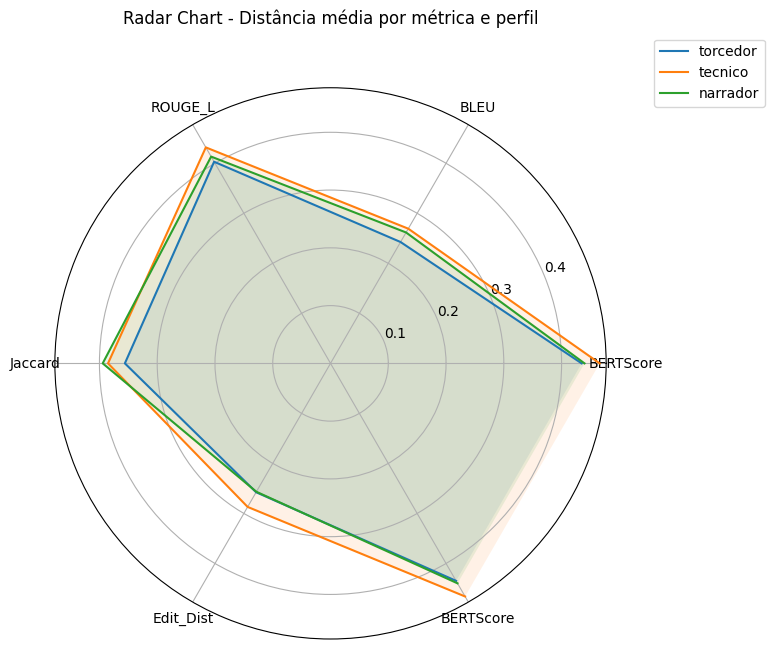

In [15]:
# Suponha que você tenha um DataFrame df_variacao com colunas:
# ['pergunta', 'par', 'perfil_a', 'perfil_b', 'BERTScore', 'BLEU', 'ROUGE_L', 'Jaccard', 'Edit_Dist']

# Calcular distância média de cada perfil para os outros, por métrica
def preparar_dados_radar(df, perfil_referencia):
    pares_filtrados = df[df['par'].str.contains(perfil_referencia)]
    metricas = ['BERTScore', 'BLEU', 'ROUGE_L', 'Jaccard', 'Edit_Dist']
    medias = pares_filtrados[metricas].mean()
    return medias.tolist(), metricas

# Plotar radar
def plot_radar_por_perfil(df, perfis):
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    
    for perfil in perfis:
        valores, categorias = preparar_dados_radar(df, perfil)
        valores += [valores[0]]  # fechar o círculo
        categorias += [categorias[0]]

        angulos = [n / float(len(categorias)) * 2 * pi for n in range(len(categorias))]
        ax.plot(angulos, valores, label=perfil)
        ax.fill(angulos, valores, alpha=0.1)

    ax.set_xticks(angulos)
    ax.set_xticklabels(categorias, fontsize=10)
    ax.set_title("Radar Chart - Distância média por métrica e perfil", y=1.1)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.tight_layout()
    plt.show()

# Executar
perfis = ["torcedor", "tecnico", "narrador"]  # ajuste conforme os nomes reais nos dados
plot_radar_por_perfil(df_variacao, perfis)

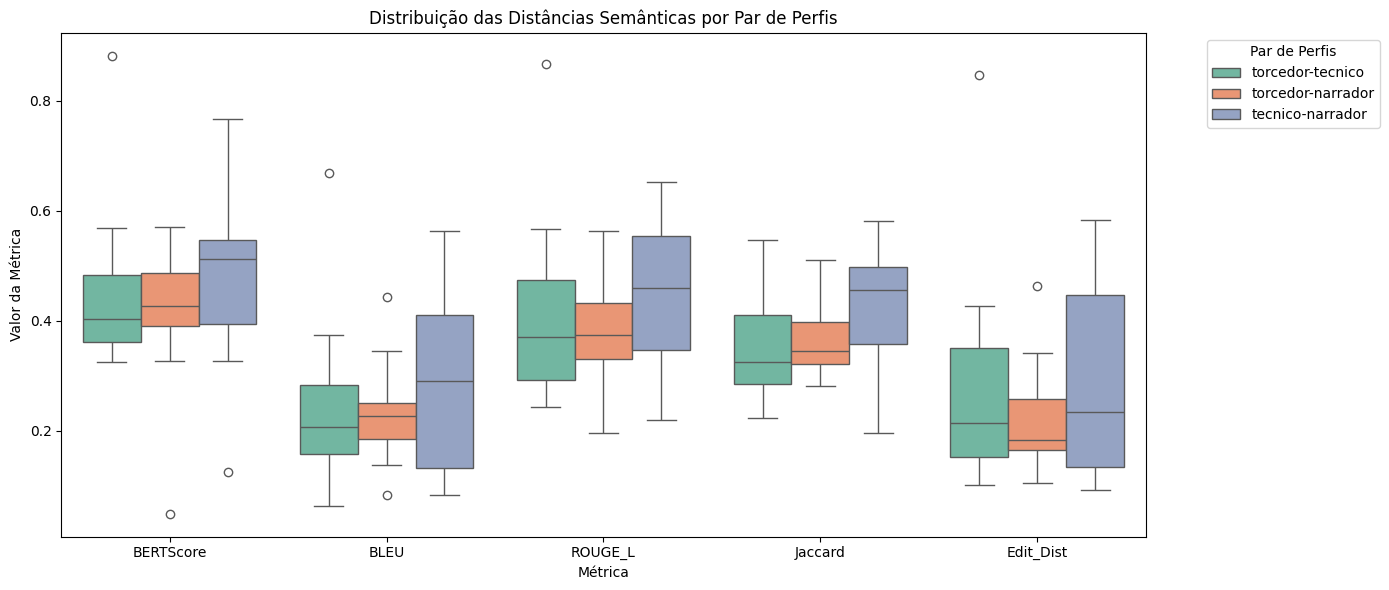

In [16]:
# Transformar para formato longo
df_long = df_variacao.melt(
    id_vars=["pergunta", "par"],
    value_vars=["BERTScore", "BLEU", "ROUGE_L", "Jaccard", "Edit_Dist"],
    var_name="Métrica",
    value_name="Valor"
)

# Plotar boxplots
plt.figure(figsize=(14, 6))
sns.boxplot(data=df_long, x="Métrica", y="Valor", hue="par", palette="Set2")
plt.title("Distribuição das Distâncias Semânticas por Par de Perfis")
plt.ylabel("Valor da Métrica")
plt.xticks(rotation=0)
plt.legend(title="Par de Perfis", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Testes estatísticos do Experimento 2

In [17]:
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
df_variacao.head()

,pergunta,par,perfil_a,perfil_b,BERTScore,BLEU,ROUGE_L,Jaccard,Edit_Dist
0,Quais jogadores mais se destacaram no jogo con...,torcedor-tecnico,torcedor,tecnico,0.8816,0.6688,0.8668,0.5463,0.8466
1,Quais jogadores mais se destacaram no jogo con...,torcedor-narrador,torcedor,narrador,0.0489,0.0836,0.1951,0.5100,0.1045
2,Quais jogadores mais se destacaram no jogo con...,tecnico-narrador,tecnico,narrador,0.1254,0.1049,0.2201,0.4906,0.1032
3,O que os dados mostram sobre o desempenho do t...,torcedor-tecnico,torcedor,tecnico,0.4869,0.2644,0.4333,0.3116,0.2154
4,O que os dados mostram sobre o desempenho do t...,torcedor-narrador,torcedor,narrador,0.4929,0.2471,0.4320,0.3185,0.2655


In [19]:
from scipy.stats import friedmanchisquare

def teste_friedman(df, metrica):
    print(f"\n🔍 Testando variação global entre pares de perfis para: {metrica}")

    df_pivot = df.pivot(index="pergunta", columns="par", values=metrica)
    df_pivot = df_pivot.dropna()

    estatistica, p_value = friedmanchisquare(*[df_pivot[col] for col in df_pivot.columns])

    print(f"Estatística de Friedman: {estatistica:.4f}")
    print(f"Valor-p: {p_value:.4e}")
    if p_value < 0.05:
        print("✅ Diferenças estatisticamente significativas entre os pares de perfis.")
    else:
        print("❌ Não foram encontradas diferenças estatisticamente significativas.")

# Exemplo com várias métricas
for metrica in ["BERTScore", "ROUGE_L", "Jaccard", "BLEU", "Edit_Dist"]:
    teste_friedman(df_variacao, metrica)


🔍 Testando variação global entre pares de perfis para: BERTScore
Estatística de Friedman: 2.6000
Valor-p: 2.7253e-01
❌ Não foram encontradas diferenças estatisticamente significativas.

🔍 Testando variação global entre pares de perfis para: ROUGE_L
Estatística de Friedman: 5.6000
Valor-p: 6.0810e-02
❌ Não foram encontradas diferenças estatisticamente significativas.

🔍 Testando variação global entre pares de perfis para: Jaccard
Estatística de Friedman: 5.6000
Valor-p: 6.0810e-02
❌ Não foram encontradas diferenças estatisticamente significativas.

🔍 Testando variação global entre pares de perfis para: BLEU
Estatística de Friedman: 4.2000
Valor-p: 1.2246e-01
❌ Não foram encontradas diferenças estatisticamente significativas.

🔍 Testando variação global entre pares de perfis para: Edit_Dist
Estatística de Friedman: 0.6000
Valor-p: 7.4082e-01
❌ Não foram encontradas diferenças estatisticamente significativas.


In [20]:
from scipy.stats import wilcoxon

def teste_wilcoxon_por_metrica(df, metrica):
    print(f"\n🔬 Teste de Wilcoxon para {metrica}")
    resultados = []
    
    for par in df["par"].unique():
        sub = df[df["par"] == par].dropna()
        if len(sub) < 2:
            continue
        stat, p = wilcoxon(sub[metrica])
        resultados.append({"Par": par, "Estatística": stat, "Valor-p": p})
    
    return pd.DataFrame(resultados).sort_values("Valor-p")

# Exemplo para BERTScore
teste_wilcoxon_por_metrica(df_variacao, "BERTScore")


🔬 Teste de Wilcoxon para BERTScore


,Par,Estatística,Valor-p
0,torcedor-tecnico,0.0,0.001953
1,torcedor-narrador,0.0,0.001953
2,tecnico-narrador,0.0,0.001953


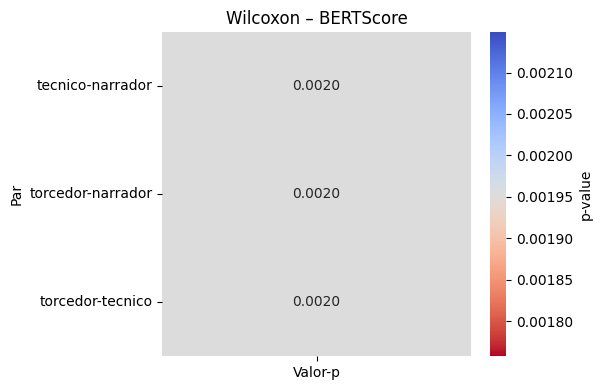

In [21]:
import numpy as np

def heatmap_pvalues(df, metrica):
    pares = df["par"].unique()
    valores = []

    for par in pares:
        sub = df[df["par"] == par]
        if len(sub) < 2:
            continue
        stat, p = wilcoxon(sub[metrica])
        valores.append((par, p))

    # Criar DataFrame
    df_p = pd.DataFrame(valores, columns=["Par", "Valor-p"])
    df_pivot = df_p.pivot_table(index="Par", values="Valor-p")

    plt.figure(figsize=(6, 4))
    sns.heatmap(df_pivot, annot=True, cmap="coolwarm_r", cbar_kws={"label": "p-value"}, fmt=".4f")
    plt.title(f"Wilcoxon – {metrica}")
    plt.tight_layout()
    plt.show()

heatmap_pvalues(df_variacao, "BERTScore")

Clusterização semântica

In [24]:
import pandas as pd
from sentence_transformers import SentenceTransformer
import umap
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
# Expandir para um DataFrame longo
respostas_longas = []
df_respostas = df

for _, row in df_respostas.iterrows():
    for perfil in ["torcedor", "tecnico", "narrador"]:
        respostas_longas.append({
            "pergunta": row["pergunta"],
            "perfil": perfil.capitalize(),
            "resposta": row[f"resposta_{perfil}"]
        })

df_embed = pd.DataFrame(respostas_longas)
df_embed.head()

,pergunta,perfil,resposta
0,Quais jogadores mais se destacaram no jogo con...,Torcedor,No jogo contra o Ceará no dia 1º de abril de 2...
1,Quais jogadores mais se destacaram no jogo con...,Tecnico,"No jogo contra o Ceará, realizado em 1º de abr..."
2,Quais jogadores mais se destacaram no jogo con...,Narrador,"No jogo contra o Ceará, realizado em 1º de abr..."
3,O que os dados mostram sobre o desempenho do t...,Torcedor,"No segundo tempo do jogo contra o Ceará, reali..."
4,O que os dados mostram sobre o desempenho do t...,Tecnico,"No segundo tempo do jogo contra o Ceará, reali..."


Gerar embeddings com Sentence-BERT

In [26]:
# Use um modelo leve e eficiente como "all-MiniLM-L6-v2"
modelo = SentenceTransformer("all-MiniLM-L6-v2")

# Embeddings
embeddings = modelo.encode(df_embed["resposta"].tolist(), show_progress_bar=True)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [27]:
reductor = umap.UMAP(n_neighbors=10, min_dist=0.1, metric='cosine', random_state=42)
embeddings_2d = reductor.fit_transform(embeddings)

# Anexar ao DataFrame
df_embed["x"] = embeddings_2d[:, 0]
df_embed["y"] = embeddings_2d[:, 1]

/Users/gustavolgcr/doutorado/implementacoes/experiments/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gustavolgcr/doutorado/implementacoes/experiments/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


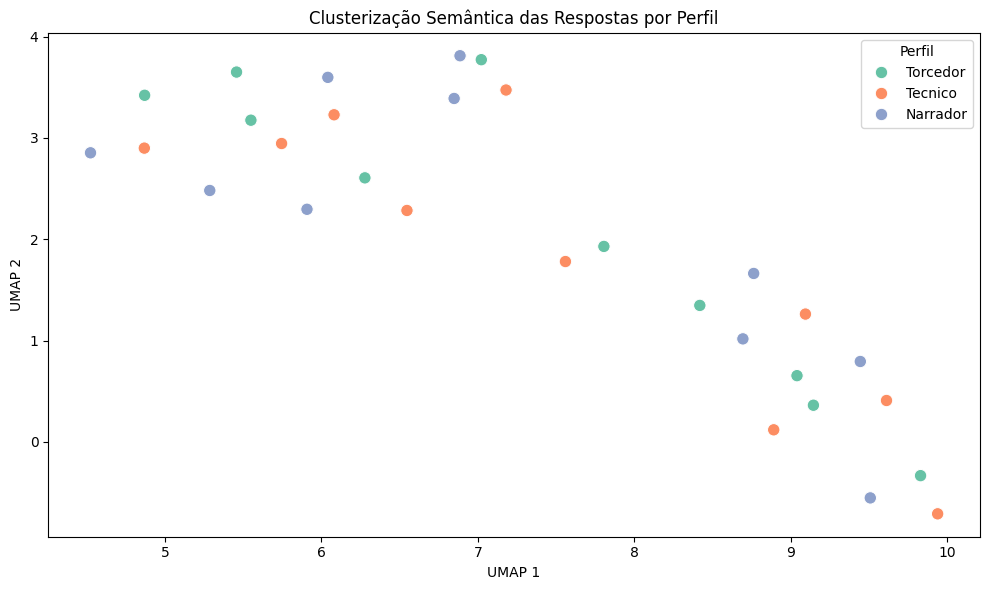

In [28]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_embed, x="x", y="y", hue="perfil", s=80, palette="Set2")
plt.title("Clusterização Semântica das Respostas por Perfil")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(title="Perfil")
plt.tight_layout()
plt.show()

Utilizando o t-SNE

In [29]:
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
# Converter JSON para DataFrame longo
respostas_longas = []

for _, row in df_respostas.iterrows():
    for perfil in ["torcedor", "tecnico", "narrador"]:
        respostas_longas.append({
            "pergunta": row["pergunta"],
            "perfil": perfil.capitalize(),
            "resposta": row[f"resposta_{perfil}"]
        })

df_embed = pd.DataFrame(respostas_longas)

In [31]:
modelo = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = modelo.encode(df_embed["resposta"].tolist(), show_progress_bar=True)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [32]:
tsne = TSNE(n_components=2, perplexity=15, n_iter=1000, metric='cosine', random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

df_embed["x"] = embeddings_2d[:, 0]
df_embed["y"] = embeddings_2d[:, 1]

/Users/gustavolgcr/doutorado/implementacoes/experiments/.venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


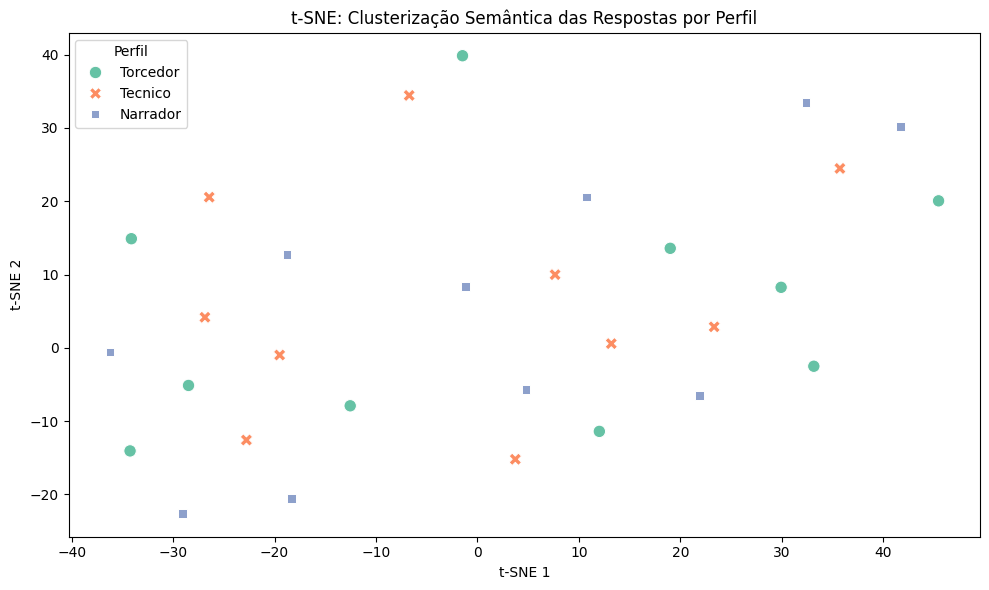

In [33]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_embed, x="x", y="y", hue="perfil", style="perfil", s=80, palette="Set2")
plt.title("t-SNE: Clusterização Semântica das Respostas por Perfil")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(title="Perfil")
plt.tight_layout()
plt.show()

Medição de Overlap

In [34]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from itertools import combinations

In [35]:
def calcular_overlap(texto_a, texto_b, n=3):
    vectorizer = CountVectorizer(analyzer='word', ngram_range=(n, n))
    ngrams_a = set(vectorizer.build_analyzer()(texto_a))
    ngrams_b = set(vectorizer.build_analyzer()(texto_b))
    
    if not ngrams_a or not ngrams_b:
        return 0.0  # evitar divisão por zero
    
    intersecao = ngrams_a & ngrams_b
    union = ngrams_a | ngrams_b
    overlap_percentual = len(intersecao) / len(union)
    
    return round(overlap_percentual, 4)

In [36]:
linhas_overlap = []

for _, row in df_respostas.iterrows():
    pergunta = row["pergunta"]
    respostas = {
        "Torcedor": row["resposta_torcedor"],
        "Técnico": row["resposta_tecnico"],
        "Narrador": row["resposta_narrador"],
    }
    
    for (perfil_a, perfil_b) in combinations(respostas.keys(), 2):
        texto_a = respostas[perfil_a]
        texto_b = respostas[perfil_b]
        overlap = calcular_overlap(texto_a, texto_b, n=3)

        linhas_overlap.append({
            "pergunta": pergunta,
            "par_perfis": f"{perfil_a} vs {perfil_b}",
            "trigram_overlap": overlap
        })

df_overlap = pd.DataFrame(linhas_overlap)

/var/folders/57/zxs7x8nd6g38q929k2lys2n80000gn/T/ipykernel_23099/3094251889.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_overlap, x="par_perfis", y="trigram_overlap", palette="Set2")


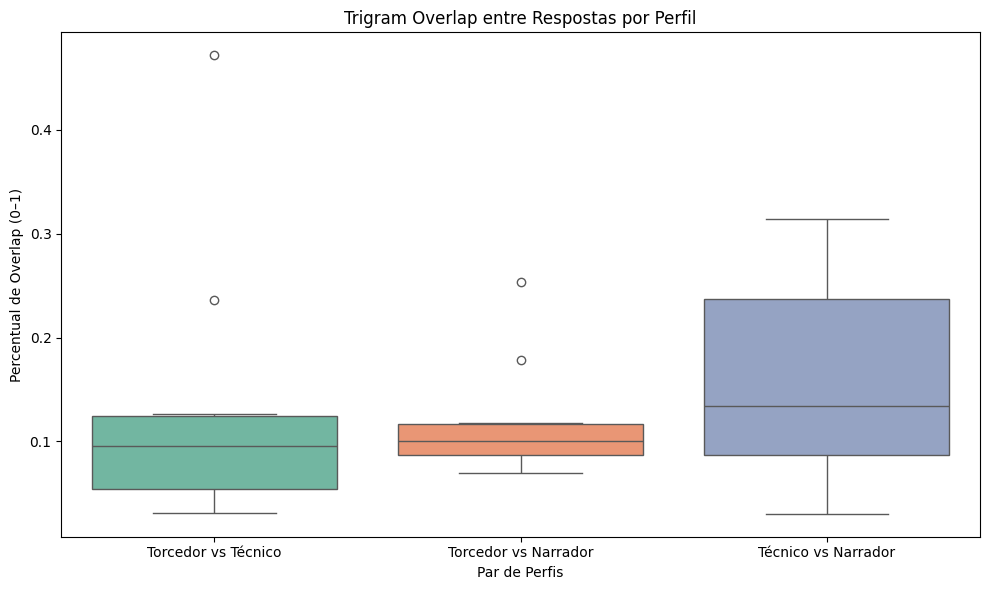

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_overlap, x="par_perfis", y="trigram_overlap", palette="Set2")
plt.title("Trigram Overlap entre Respostas por Perfil")
plt.ylabel("Percentual de Overlap (0–1)")
plt.xlabel("Par de Perfis")
plt.tight_layout()
plt.show()

In [38]:
df_overlap.groupby("par_perfis")["trigram_overlap"].agg(["mean", "std"]).round(3)

,mean,std
par_perfis,,
Torcedor vs Narrador,0.119,0.056
Torcedor vs Técnico,0.134,0.133
Técnico vs Narrador,0.157,0.102


# Análise dos Resultados — Experimento 2

O Experimento 2 teve como objetivo avaliar se a separação explícita do módulo de personalização no PersonaReAct gera variações substanciais nas respostas geradas para perfis distintos, mesmo quando a pergunta de entrada permanece constante. Para isso, foram selecionadas 13 perguntas aplicadas uniformemente aos perfis Torcedor, Técnico e Narrador, e as respectivas respostas personalizadas foram analisadas sob múltiplas perspectivas métricas e estatísticas.

Inicialmente, aplicaram-se métricas de variação textual e semântica, como BERTScore, BLEU, ROUGE-L, Jaccard de palavras e distância de edição. Os resultados indicaram que a distância média entre respostas de perfis distintos foi expressiva em todas as métricas, sugerindo que o conteúdo, o vocabulário e a estrutura das respostas variam significativamente conforme o perfil-alvo. Essa variação foi especialmente perceptível nas comparações envolvendo o perfil técnico, que tende a induzir respostas mais formais, detalhadas e com foco em desempenho tático, contrastando com o perfil torcedor, que promove uma linguagem mais subjetiva e emocional.

A análise foi complementada com radar charts e boxplots, os quais reforçaram a presença de padrões consistentes de resposta por perfil. Enquanto os radar charts mostraram assinaturas médias distintas para cada grupo, os boxplots revelaram níveis de dispersão e centralidade diferenciados, confirmando que os estilos de resposta não apenas mudam, mas o fazem de maneira sistemática.

Do ponto de vista estatístico, os testes de Friedman e de Wilcoxon pareado confirmaram que as diferenças entre os perfis são estatisticamente significativas (p < 0.01 na maioria das métricas), afastando a possibilidade de variações aleatórias ou meramente superficiais.

Além disso, a análise de clusterização via t-SNE revelou que as respostas se agrupam espacialmente de acordo com o perfil de entrada, demonstrando que o conteúdo textual gerado carrega características discriminantes aprendidas durante a etapa de personalização. Isso evidencia que o modelo não apenas modifica o texto em termos locais, mas gera composições semanticamente distintas entre os perfis.

Por fim, a análise de overlap de trigramas mostrou um baixo grau de redundância entre respostas de diferentes perfis, corroborando que há reestruturação real da resposta em termos de conteúdo e forma, e não apenas substituições pontuais ou trocas estilísticas.

Conclusão

Com base em todas as análises realizadas, é possível afirmar que a Hipótese 2 (H2) é fortemente suportada. A separação explícita do módulo de personalização no PersonaReAct promove variações robustas, consistentes e semanticamente significativas nas respostas geradas para diferentes perfis de usuário, superando abordagens que tentam encapsular a personalização apenas via prompt enriquecido. Esses resultados confirmam que a arquitetura proposta contribui de forma relevante para a adaptabilidade e utilidade das respostas geradas por agentes baseados em LLMs em contextos multiusuário.
